# 3. Third Version: Encoding 변화
- 장르: Multi-Hot -> FlixPatrol 사이트 참조하여 각 장르의 점수의 평균 계산
- 제작 국가: Label -> Target encoding(PCA평균값)
---
- 다중선형회귀 시도
- 군집화 시도

In [112]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


from sklearn.model_selection import learning_curve

In [113]:
# 데이터 불러오기
df = pd.read_excel('../data/file/ml_all.xlsx', index_col=0)

## 01-1. 제작 국가 인코딩 바꾸기-target encoding

In [114]:
# 각 범주(나라)의 타겟 변수(여기서는 PCA 평균) 계산
country_means = df.groupby('production_country')['PCA'].mean()

# 타겟 인코딩 적용
df['production_country_encoded'] = df['production_country'].map(country_means)

In [115]:
print(country_means)

production_country
남아프리카공화국    0.309786
네덜란드       -1.647491
노르웨이        0.897731
뉴질랜드        0.630142
대만         -0.142808
대한민국       -0.361577
덴마크         0.907856
독일          1.634898
러시아         0.492123
룩셈부르크       0.387385
멕시코         0.006195
미국          2.452330
벨기에         0.649214
브라질        -0.002870
스웨덴         0.984878
스페인         1.030830
아르헨티나       0.400193
아이슬란드       1.584064
영국          2.804395
이스라엘        1.961163
이탈리아       -0.509365
인도          1.212922
일본         -0.769458
캐나다         1.905836
콜롬비아       -0.417882
태국         -0.786701
터키          0.553134
폴란드        -0.357281
프랑스        -0.563153
핀란드         0.558147
호주          0.970899
Name: PCA, dtype: float64


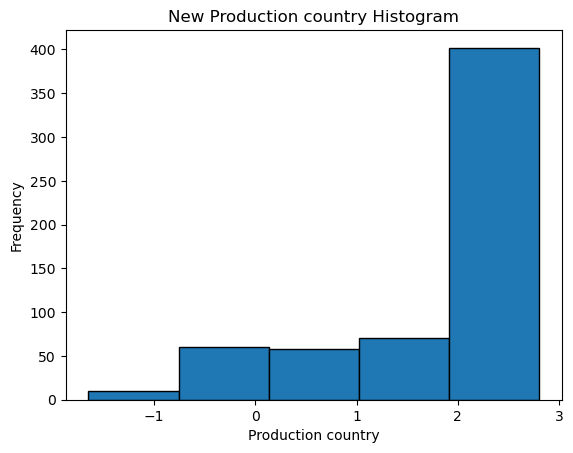

In [116]:
# 히스토그램 그리기
plt.hist(df['production_country_encoded'], bins=5, edgecolor='black')
plt.title('New Production country Histogram')
plt.xlabel('Production country')
plt.ylabel('Frequency')

# 그래프 보여주기
plt.show()

## 01-2. 장르마다 각 값 부여
- 모델의 객관성을 위해 넷플릭스 통계 사이트를 활용함
    - 2023년 넷플릭스 시청 보고서를 참조(FlixPatrol, 'Preferences on Netflix in Q2 2024')

In [117]:
# 넷플릭스 장르 선호도 순위 리스트 (선호도 순서대로 정렬)
genres = [
    '드라마', '코미디', 'SF', '액션', '스릴러', '범죄', '공포', '로맨스', '판타지', '전쟁', '서부', '그 외'
]

# 각 장르에 점수를 선형적으로 할당하여 딕셔너리로 만들기
genre_scores = {genre: 1 - i / (len(genres)) for i, genre in enumerate(genres)}

# '그 외'에 해당되는 장르 리스트
other_genres = ['역사', '가족', '음악', 'Made in Europe', '스포츠']

# 장르 문자열을 받아서 점수를 계산하는 함수

def get_genre_score(genre_str):
    # 장르를 ', '로 분리
    genre_list = genre_str.split(', ')
    
    # '그 외'에 포함된 하위 장르가 있는지 확인
    for genre in genre_list:
        if genre in other_genres:
            return genre_scores['그 외']
    
    # 각 장르의 점수의 평균 계산
    total_score = 0
    count = 0
    for genre in genre_list:
        score = genre_scores.get(genre, genre_scores['그 외'])  # 없는 장르는 '그 외' 점수로 처리
        total_score += score
        count += 1
    
    # 평균 점수 계산
    average_score = total_score / count if count > 0 else 0
    return average_score

# 장르별 점수
df['genre'] = df['genre'].apply(get_genre_score)

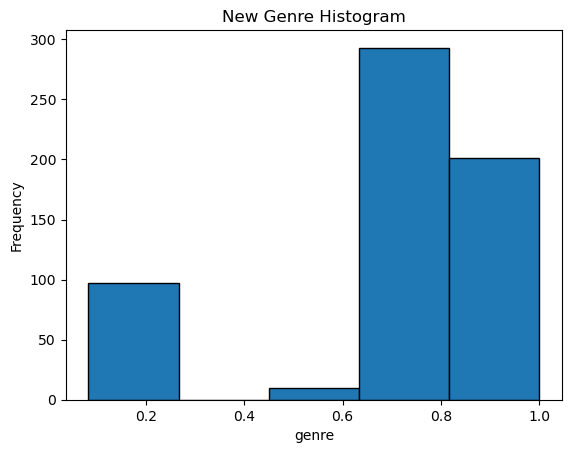

In [118]:
# 히스토그램 그리기
plt.hist(df['genre'], bins=5, edgecolor='black')
plt.title('New Genre Histogram')
plt.xlabel('genre')
plt.ylabel('Frequency')

# 그래프 보여주기
plt.show()

---

## 02-1. Modeling

In [119]:
# 로그 변환 적용 

df['i_s2_rate_cnt'] = np.log1p(df['i_s2_rate_cnt'])  # log(1+x) 변환 사용
df['w_s2_rate_cnt'] = np.log1p(df['w_s2_rate_cnt'])
df['s2_rate_cnt_retention'] = np.log1p(df['s2_rate_cnt_retention'])
df['s1_gap_days'] = np.log1p(df['s1_gap_days'])
df['age_rating'] = np.log1p(df['age_rating'])
df['season_gaps_days'] = np.log1p(df['season_gaps_days'])
df['i_s1_rate_cnt'] = np.log1p(df['i_s1_rate_cnt'])
df['w_s1_rate_cnt'] = np.log1p(df['w_s1_rate_cnt'])
df['s1_rate_cnt_retention'] = np.log1p(df['s1_rate_cnt_retention'])

In [120]:
# Score(y값)
rate = (0.8 * df['i_s2_rate']) + (0.2 * df['w_s2_rate'])
cnt = (0.8 * df['i_s2_rate_cnt']) + (0.2 * df['w_s2_rate_cnt'])
ret = (0.4 * df['s2_rate_retention']) + (0.6 * df['s2_rate_cnt_retention'])
total = (0.3 * rate + 0.5 * cnt + 0.2 * ret) *10

# 점수를 데이터프레임에 추가
df['score'] = total

In [121]:
df = df[['runtime','genre','age_rating','production_country_encoded','PCA','genre_len','seson_n','i_s1_rate','i_s1_rate_cnt','s1_rate_retention','s1_rate_cnt_retention','w_s1_rate','w_s1_rate_cnt','s1_gap_days','season_gaps_days','score']]

In [122]:
X = df.drop(['score'], axis=1)  # 'score' 열을 제외한 모든 열 선택
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [160]:
# DecisionTreeRegressor 모델 초기화
dt_model = DecisionTreeRegressor(random_state=13)
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)

# 회귀 모델의 성능 평가
dt_mse = mean_squared_error(y_test, predictions)
dt_mae = mean_absolute_error(y_test, predictions)
dt_r2 = r2_score(y_test, predictions)

In [161]:
# RandomForestRegressor 모델 초기화
rf_model = RandomForestRegressor(random_state=13)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

# 회귀 모델의 성능 평가
rf_mse = mean_squared_error(y_test, predictions)
rf_mae = mean_absolute_error(y_test, predictions)
rf_r2 = r2_score(y_test, predictions)

In [162]:
# KNeighborsRegressor 모델 초기화
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# 회귀 모델의 성능 평가
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)

In [163]:
# XGBRegressor 모델 초기화
xgb_model = XGBRegressor(random_state=13)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# 회귀 모델의 성능 평가
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

In [164]:
# AdaBoostRegressor 모델 초기화
ada_model = AdaBoostRegressor(random_state=13)
ada_model.fit(X_train, y_train)
ada_predictions = ada_model.predict(X_test)

# 회귀 모델의 성능 평가
ada_mse = mean_squared_error(y_test, ada_predictions)
ada_mae = mean_absolute_error(y_test, ada_predictions)
ada_r2 = r2_score(y_test, ada_predictions)

In [ ]:
# LGBMRegressor 모델 초기화
lgbm_model = LGBMRegressor(random_state=13)
lgbm_model.fit(X_train, y_train)
lgbm_predictions = lgbm_model.predict(X_test)

# 회귀 모델의 성능 평가
lgbm_mse = mean_squared_error(y_test, lgbm_predictions)
lgbm_mae = mean_absolute_error(y_test, lgbm_predictions)
lgbm_r2 = r2_score(y_test, lgbm_predictions)

In [166]:
# GradientBoostingRegressor 모델 초기화
gbr_model = GradientBoostingRegressor(random_state=13)
gbr_model.fit(X_train, y_train)
gbr_predictions = gbr_model.predict(X_test)

# 회귀 모델의 성능 평가
gbr_mse = mean_squared_error(y_test, gbr_predictions)
gbr_mae = mean_absolute_error(y_test, gbr_predictions)
gbr_r2 = r2_score(y_test, gbr_predictions)

In [167]:
# LinearRegression 모델 초기화
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# LinearRegression 모델의 성능 평가
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

---

## 02-2. 모델링 결과

In [131]:
model_result = pd.DataFrame({
    'MSE': [dt_mse, rf_mse, knn_mse, xgb_mse, ada_mse, lgbm_mse, gbr_mse, lr_mse],
    'MAE': [dt_mae, rf_mae, knn_mae, xgb_mae, ada_mae, lgbm_mae, gbr_mae, lr_mae],
    'R2': [dt_r2, rf_r2, knn_r2, xgb_r2, ada_r2, lgbm_r2, gbr_r2, lr_r2]
}, index=['DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 'XGBoostRegressor', 'AdaBoostRegressor', 'LightGBMRegressor', 'GradientBoostingRegressor', 'LinearRegression'])
print(model_result)

                                 MSE       MAE        R2
DecisionTreeRegressor       9.525449  2.420046  0.890042
RandomForestRegressor       4.400769  1.559621  0.949199
KNeighborsRegressor        12.259306  2.706040  0.858483
XGBoostRegressor            5.293754  1.650999  0.938891
AdaBoostRegressor           6.242849  1.987691  0.927935
LightGBMRegressor           3.741206  1.498937  0.956813
GradientBoostingRegressor   3.075514  1.337856  0.964497
LinearRegression            2.956189  1.328964  0.965875


In [132]:
# prompt: 제일 좋은 성능 두가지
print("MSE 기준")
print(model_result.sort_values(by=['MSE'], ascending=True).head(3))
print(" ")

print("MAE 기준")
print(model_result.sort_values(by=['MAE'], ascending=True).head(3))
print(" ")

print("R2 기준")
print(model_result.sort_values(by=['R2'], ascending=False).head(3))

MSE 기준
                                MSE       MAE        R2
LinearRegression           2.956189  1.328964  0.965875
GradientBoostingRegressor  3.075514  1.337856  0.964497
LightGBMRegressor          3.741206  1.498937  0.956813
 
MAE 기준
                                MSE       MAE        R2
LinearRegression           2.956189  1.328964  0.965875
GradientBoostingRegressor  3.075514  1.337856  0.964497
LightGBMRegressor          3.741206  1.498937  0.956813
 
R2 기준
                                MSE       MAE        R2
LinearRegression           2.956189  1.328964  0.965875
GradientBoostingRegressor  3.075514  1.337856  0.964497
LightGBMRegressor          3.741206  1.498937  0.956813


---

# < 아래는 여러 시도를 해보았지만, 성능이 향상되지 않았던 케이스들>

## 03-1. 다중선형회귀 시도

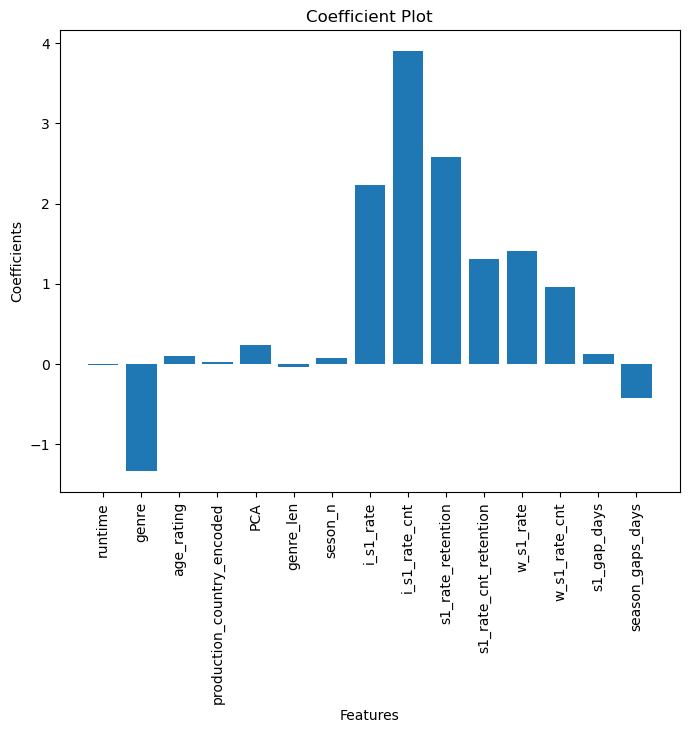

In [133]:
# 모델의 계수를 구합니다.
coefficients = lr_model.coef_
feature_names = df.columns[:-1]  # 마지막 컬럼(Target)을 제외한 컬럼명 사용

# 패러미터 플롯을 생성합니다.
plt.figure(figsize=(8, 6))
plt.bar(feature_names, coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Coefficient Plot')
plt.xticks(rotation=90)  # x축 레이블을 90도 회전
plt.show()

In [134]:
# 중요 특성 선택
X_important_features = df[['i_s1_rate_cnt', 's1_rate_retention','i_s1_rate']]  # 중요 특성 값들로 이루어진 데이터

# 종속 변수 값
y = df['score']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_important_features, y, test_size=0.2, random_state=42)

# 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# LinearRegression 모델의 성능 평가
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

In [135]:
model_result = pd.DataFrame({'MSE': [lr_mse], 'MAE': [lr_mae], 'R2': [lr_r2]}, index=['LinearRegression'])
print(model_result)

                       MSE       MAE        R2
LinearRegression  6.775586  2.033326  0.917875


- LinearRegression의 중요 특성 3가지로 다중선형회귀를 시도해보았으나 성능이 좋지 않았기에 pass

## 03-2. 군집화(runtime에 의해 군집 0,1로 나뉨) 시도

In [136]:
df_clu = df[['runtime','genre','age_rating','production_country_encoded','PCA','genre_len','seson_n','i_s1_rate','i_s1_rate_cnt','s1_rate_retention','s1_rate_cnt_retention','w_s1_rate','w_s1_rate_cnt','s1_gap_days','season_gaps_days']]

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# 군집수에 따른 실루엣계수를 담을 리스트
silhouette_scores = []

# 2~10까지 군집수를 변화시키며 실루엣계수를 계산
for n_clusters in range(2, 16):
    # KMeans 군집화 수행
    kmeans = KMeans(n_clusters=n_clusters, random_state=13)
    kmeans.fit(df_clu)

    # 실루엣계수 계산
    silhouette_score_ = silhouette_score(df_clu, kmeans.labels_)
    silhouette_scores.append(silhouette_score_)

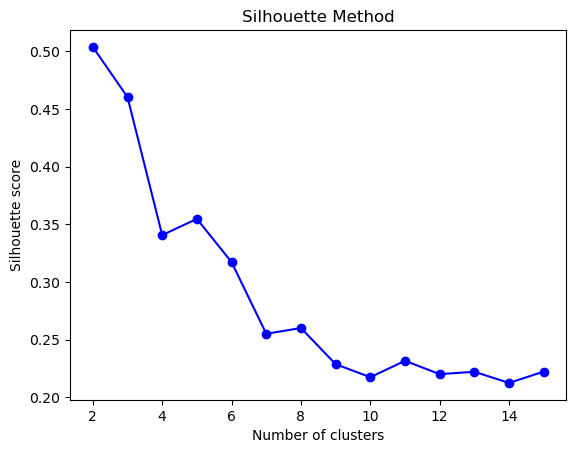

In [138]:
# 군집수에 따른 실루엣계수 그래프 그리기
plt.plot(range(2, 16), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.show()

In [139]:
from sklearn.cluster import KMeans
import plotly.graph_objects as go

# KMeans 군집화
kmeans = KMeans(n_clusters=2, random_state=13)
cluster_labels = kmeans.fit_predict(df_clu)

# 군집 레이블을 기준으로 데이터프레임에 추가
df_clu['cluster'] = cluster_labels

# 클러스터별로 데이터 분리
clusters = []
for i in range(2):
    clusters.append(df_clu[df_clu['cluster'] == i])

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


클러스터 중심 (centroids):
     runtime     genre  age_rating  production_country_encoded       PCA  \
0  48.198257  0.695358    2.845690                    1.878335  2.133059   
1  28.838028  0.678472    2.834664                    1.825148  1.001781   

   genre_len   seson_n  i_s1_rate  i_s1_rate_cnt  s1_rate_retention  \
0   3.287582  3.490196   7.866643       6.997341           1.058970   
1   2.739437  2.725352   7.597046       5.715992           1.075438   

   s1_rate_cnt_retention  w_s1_rate  w_s1_rate_cnt  s1_gap_days  \
0               0.642234   3.523529       6.995870     3.580059   
1               0.600024   3.382394       6.070599     2.174633   

   season_gaps_days  
0          5.710258  
1          5.839147  

클러스터별 특성 평균 값:
           runtime     genre  age_rating  production_country_encoded  \
cluster                                                                
0        48.198257  0.695358    2.845690                    1.878335   
1        28.838028  0.678472    2.83

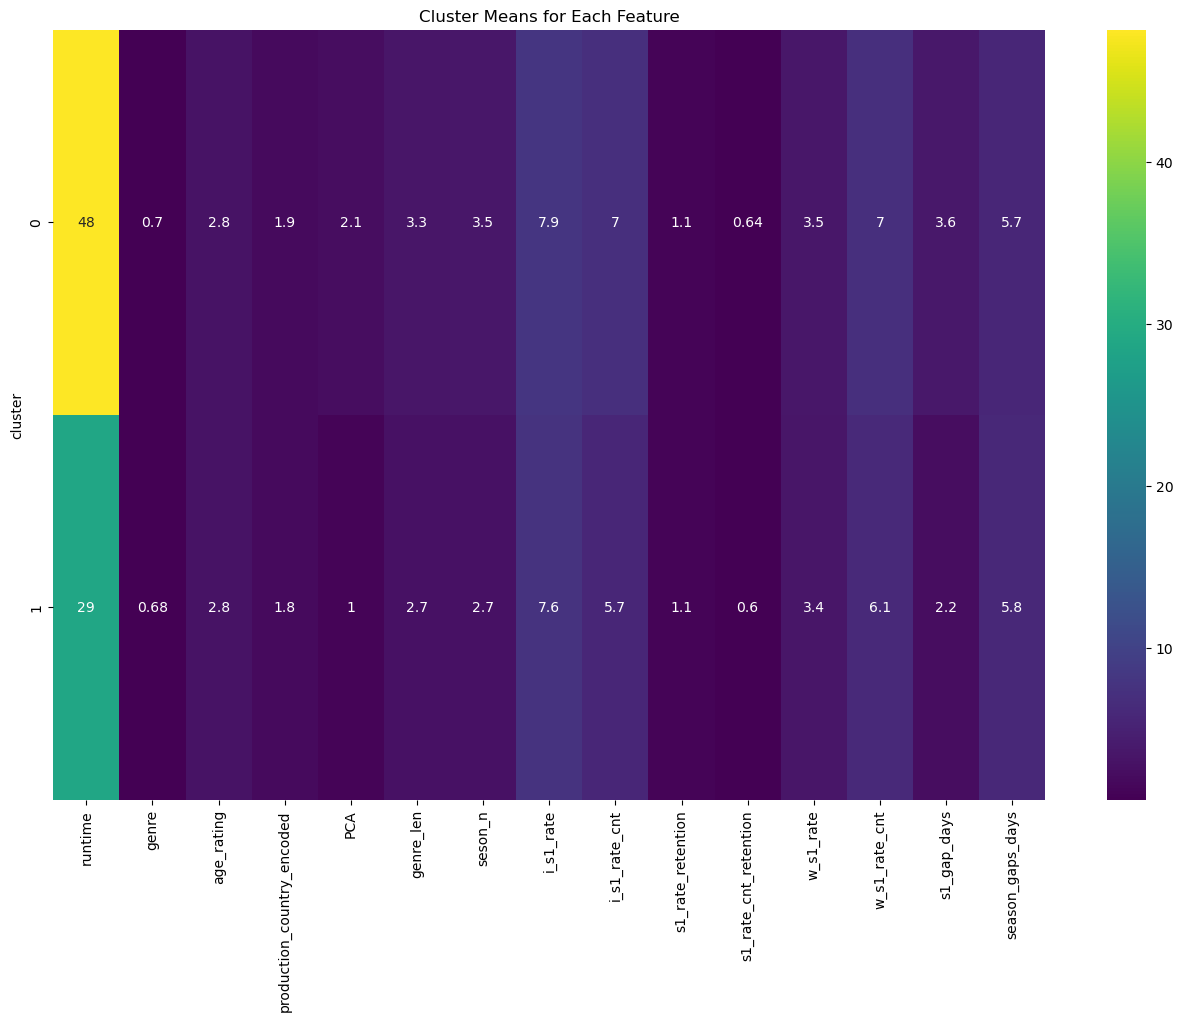

In [140]:
features = ['runtime','genre','age_rating','production_country_encoded','PCA','genre_len','seson_n','i_s1_rate','i_s1_rate_cnt','s1_rate_retention','s1_rate_cnt_retention','w_s1_rate','w_s1_rate_cnt','s1_gap_days','season_gaps_days']

# 각 클러스터의 중심 (centroid) 확인
cluster_centers = kmeans.cluster_centers_

# 클러스터 중심을 데이터프레임으로 변환
centroids_df = pd.DataFrame(cluster_centers, columns=features)

# 클러스터별 특성의 평균 값 계산
cluster_means = df_clu.groupby('cluster').mean()

# 결과 출력
print("클러스터 중심 (centroids):")
print(centroids_df)
print("\n클러스터별 특성 평균 값:")
print(cluster_means)

# 클러스터별로 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 클러스터별 특성 평균 값 시각화
plt.figure(figsize=(16, 10))
sns.heatmap(cluster_means[features], annot=True, cmap='viridis')
plt.title('Cluster Means for Each Feature')
plt.show()

In [141]:
# 각 클러스터에 속한 데이터 포인트의 수 확인
cluster_counts = df_clu['cluster'].value_counts()

# 각 클러스터의 데이터 포인트 수 출력
for cluster_num in range(2):
    print(f"Cluster {cluster_num} has {cluster_counts[cluster_num]} data points.")

Cluster 0 has 459 data points.
Cluster 1 has 142 data points.


In [142]:
# 각 클러스터에 해당하는 데이터프레임 생성
df_0 = df_clu[df_clu['cluster'] == 0]
df_1 = df_clu[df_clu['cluster'] == 1]

In [143]:
# 병합을 위해 필요한 열을 포함한 새로운 데이터프레임 생성
df_for_merge = df[['s1_rate_cnt_retention', 's1_rate_retention', 'score']]

In [148]:
df_0 = pd.merge(df_0,
		df_for_merge,
        on=['s1_rate_retention','s1_rate_cnt_retention'],						# 병합시 기준 컬럼명
        how='inner'						# 디폴트값으로 how="inner"(교집합)
        )

In [144]:
df_1 = pd.merge(df_1,
		df_for_merge,
        on=['s1_rate_retention','s1_rate_cnt_retention'],						# 병합시 기준 컬럼명
        how='inner'						# 디폴트값으로 how="inner"(교집합)
        )

In [149]:
# X = df_0.drop(['score'], axis=1)  # 'score' 열을 제외한 모든 열 선택
# y = df_0['score']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [159]:
X = df_1.drop(['score'], axis=1)  # 'score' 열을 제외한 모든 열 선택
y = df_1['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### 03-2. 군집화 시도 결과

In [158]:
# 군집0 성능 지표

model_result = pd.DataFrame({
    'MSE': [dt_mse, rf_mse, knn_mse, xgb_mse, ada_mse, lgbm_mse, gbr_mse, lr_mse],
    'MAE': [dt_mae, rf_mae, knn_mae, xgb_mae, ada_mae, lgbm_mae, gbr_mae, lr_mae],
    'R2': [dt_r2, rf_r2, knn_r2, xgb_r2, ada_r2, lgbm_r2, gbr_r2, lr_r2]
}, index=['DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 'XGBoostRegressor', 'AdaBoostRegressor', 'LightGBMRegressor', 'GradientBoostingRegressor', 'LinearRegression'])
print(model_result)

                                 MSE       MAE        R2
DecisionTreeRegressor       7.663092  2.127492  0.903507
RandomForestRegressor       4.186048  1.547916  0.947290
KNeighborsRegressor        13.796548  2.750969  0.826276
XGBoostRegressor            5.165643  1.714870  0.934955
AdaBoostRegressor           6.660135  1.995285  0.916137
LightGBMRegressor           5.380465  1.706983  0.932250
GradientBoostingRegressor   4.770909  1.631051  0.939925
LinearRegression            3.681841  1.496779  0.953639


In [168]:
# 군집1 성능 지표

model_result = pd.DataFrame({
    'MSE': [dt_mse, rf_mse, knn_mse, xgb_mse, ada_mse, lgbm_mse, gbr_mse, lr_mse],
    'MAE': [dt_mae, rf_mae, knn_mae, xgb_mae, ada_mae, lgbm_mae, gbr_mae, lr_mae],
    'R2': [dt_r2, rf_r2, knn_r2, xgb_r2, ada_r2, lgbm_r2, gbr_r2, lr_r2]
}, index=['DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 'XGBoostRegressor', 'AdaBoostRegressor', 'LightGBMRegressor', 'GradientBoostingRegressor', 'LinearRegression'])
print(model_result)

                                 MSE       MAE        R2
DecisionTreeRegressor      11.950446  2.653908  0.806639
RandomForestRegressor       6.930129  2.058041  0.887869
KNeighborsRegressor        11.040899  2.570686  0.821356
XGBoostRegressor            5.157668  1.674364  0.916548
AdaBoostRegressor           8.341256  2.245675  0.865036
LightGBMRegressor           6.512733  1.973694  0.894622
GradientBoostingRegressor   5.747014  1.849503  0.907012
LinearRegression            2.498965  1.301314  0.959566


군집1(142개)는 성능이 더 좋아진 것으로 보이나, 데이터가 더 많이 있는 군집0(459개)은 성능이 더 좋지 못하기에 군집화는 하지 않기로 함